# Downloading products from GEE into netcdfs

Using package `wxee`: https://github.com/aazuspan/wxee

The default example loads `MODIS Terra thermal anomalies and Fire Daily`

> Note: Will likely need to install the two packages listed in the cell below. Uncomment, run the cell, then restart kernel.

In [ ]:
# !pip install earthengine-api
# !pip install wxee

## Load packages

In [1]:
import os
import ee
import wxee
import xarray as xr
import pandas as pd
import numpy as np

/home/547/cb3058/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Authenticate GEE    

Need to sign up: https://earthengine.google.com/new_signup/

Then run the cell and follow the link/prompts

In [2]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

Enter verification code:  4/1AX4XfWivDCfwEyZFpy0JLfWfG9miYtPdDfZVo1_d_J31aRAnJj55RqcvggE



Successfully saved authorization token.


## Analysis parameters

Enter the product name and other parameters below, you find some of this info on the product data page, e.g. https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD14A1?hl=en

> Note: For the analysis extent try using http://geojson.io/ to draw a polygon, then copy and paste the coordinates into the cell

In [18]:
product = 'MODIS/006/MOD14A1'
bands =  ['MaxFRP', 'FireMask']
start_date = '6/1/2019'
end_date = '7/1/2020'
output_path = '/g/data/os22/chad_tmp/NEE_modelling/data/fire/'
output_crs = "EPSG:3577"
resolution = 1000

# enter polygon bounds (example below covers ACT+ East NSW)
region = ee.Geometry.Polygon([
          [
            [
              147.216796875,
              -37.60552821745789
            ],
            [
              151.226806640625,
              -37.60552821745789
            ],
            [
              151.226806640625,
              -34.45221847282653
            ],
            [
              147.216796875,
              -34.45221847282653
            ],
            [
              147.216796875,
              -37.60552821745789
            ]
          ]
        ]
)


## Loop through months and load MODIS data

Doing this on a per-month basis to keep the memory usage down

In [30]:
#use start and end dates to loop through months and load GEE data
start = pd.date_range(start=start_date, end=end_date, freq='MS') 
end = pd.date_range(start=start_date, end=end_date, freq='M')

i = 0
for s, e in zip(start,end):
    print(" {:03}/{:03}\r".format(i+1, len(start)), end="")
    
    #use this to check if file already exists
    ss = s+pd.Timedelta(14, 'd')

    if os.path.isfile(output_path+product[-7:]+'_'+ss.strftime('%Y-%m')+'.nc'):
        pass
    
    else:
        try:
            s = s.strftime('%Y-%m-%d')
            e = e.strftime('%Y-%m-%d')

            #download data from GEE
            ts = wxee.TimeSeries(product).filterDate(s, e)
            ts = ts.select(bands)
            ds = ts.wx.to_xarray(region=region, scale=resolution, crs=output_crs, progress=False)
            ds.to_netcdf(output_path+product[-7:]+'_'+np.datetime_as_string(ds.time.values[0], unit='M')+'.nc')

        except:
            print('fail:', s,e)
            pass
        
    i+=1

## Optional: Stitch together monthly files into annual netcdfs

Set the three parameters below

In [33]:
year_start = 2019
year_end = 2020
annual_output_path = '/g/data/os22/chad_tmp/NEE_modelling/data/fire_annual/'

In [34]:
i=0
for y in range(year_start, year_end+1):
    print(" {:02}/{:02}\r".format(i + 1, len(range(year_start, year_end+1))), end="")
    
    year = str(y)
    files = [output_path+f for f in os.listdir(output_path) if year in f]
    
    dss=[]
    for f in files:
        ds = xr.open_dataset(f)
        dss.append(ds)
        
    data = xr.concat(dss, dim='time').sortby('time')
    data.to_netcdf(annual_output_path+product[-7:]+'_'+year+'.nc')
    i+=1

## Open and plot an example

In [43]:
ds = xr.open_dataset(annual_output_path+product[-7:]+'_'+year+'.nc')

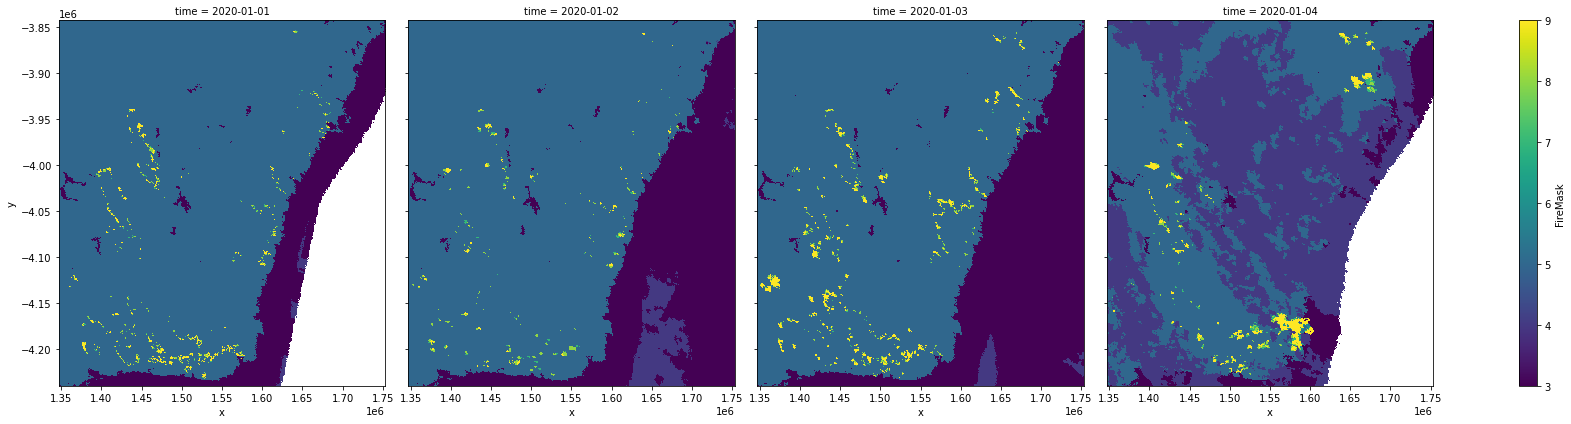

In [45]:
ds.FireMask.isel(time=slice(0,4)).plot.imshow(col='time', col_wrap=4, size=6);